In [1]:
import pandas as pd

from textblob import TextBlob

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql import Row

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# sparkSession = SparkSession \
#     .builder \
#     .appName("myApp") \
#     .config("spark.mongodb.read.connection.uri", "mongodb://127.0.0.1:27017/bdm.sentiment") \
#     .config("spark.mongodb.write.connection.uri", "mongodb://127.0.0.1/bdm.sentiment") \
#     .getOrCreate()


sparkSession = SparkSession \
    .builder \
    .appName("mongodbtest1") \
    .master('local')\
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1:27017/bdm") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1:27017/bdm") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/homebrew/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/tanishqtapiawala/.ivy2/cache
The jars for the packages stored in: /Users/tanishqtapiawala/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2cbd635c-8369-4068-b0c3-a26c8f6a2828;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 432ms :: artifacts dl 18ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules    

22/12/16 16:45:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
schema = StructType() \
                    .add("review_id", "string")\
                    .add("user_id", "string")\
                    .add("business_id", "string")\
                    .add("stars", "integer")\
                    .add("useful", "integer")\
                    .add("funny", "integer")\
                    .add("cool", "integer")\
                    .add("text", "string")\
                    .add("date", "string")

In [4]:
review=sparkSession.read.csv("hdfs://127.0.0.1:9000/fp/review.csv", schema=schema)

review.show()

+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|           review_id|             user_id|         business_id|stars|useful|funny|cool|                text|               date|
+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|KU_O5udG6zpxOg-Vc...|mh_-eMZ6K5RLWhZyI...|XQfwVwDr-v0ZS3_Cb...|    3|     0|    0|   0|If you decide to ...|               null|
|    The food is good| but it takes a v...| but usually plea...| null|  null| null|null|                null|               null|
|BiTunyQ73aT9WBnpR...|OyoGAe7OKpv6SyGZT...|7ATYjTIgM3jUlt4UM...|    5|     1|    0|   1|I've taken a lot ...|               null|
|For anyone who st...| the online sched...|                null| null|  null| null|null|                null|               null|
|There is no way I...| the owner of Bod...| a shout out. Rus...| null|  null| null|null|  

In [5]:
review = review.dropna()

In [6]:
plot_review = review.limit(500000).toPandas()

<AxesSubplot: xlabel='stars', ylabel='count'>

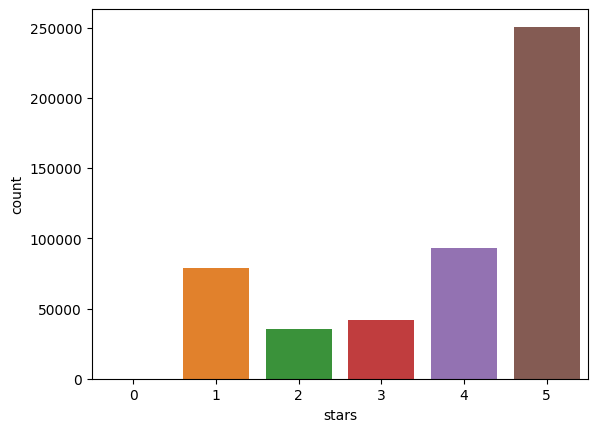

In [7]:
sns.countplot(x ='stars', data = plot_review)

In [8]:
review = review.select('text')

In [9]:
review.show()

+--------------------+
|                text|
+--------------------+
|Family diner. Had...|
|Wow!  Yummy, diff...|
|Cute interior and...|
|I am a long term ...|
|Loved this tour! ...|
|Amazingly amazing...|
|This easter inste...|
|Had a party of 6 ...|
|Locals recommende...|
|Love going here f...|
|Great place for b...|
|Tremendous servic...|
|The hubby and I h...|
|I go to blow bar ...|
|My absolute favor...|
|Upland is a brewe...|
|I thoroughly enjo...|
|Yes, this is the ...|
|Went for lunch. B...|
|Best thai food in...|
+--------------------+
only showing top 20 rows



In [10]:
# Subjective sentence expresses some personal feelings, views, or beliefs.
def getSubjectivity(chat):
    return TextBlob(chat).sentiment.subjectivity

# It simply means emotions expressed in a sentence.
def getPolarity(chat):
    return TextBlob(chat).sentiment.polarity

def getSentiment(polarityValue):
    if polarityValue < 0:
        return 'Negative'
    elif polarityValue == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [11]:
sub_score_udf = udf(lambda x: getSubjectivity(x), FloatType())
pol_score_udf = udf(lambda x: getPolarity(x), FloatType())
sen_score_udf = udf(lambda x: getSentiment(x), StringType())

In [12]:
sub = review.withColumn('subjectivity', sub_score_udf('text'))
pol = sub.withColumn('polarity', pol_score_udf('text'))
df = pol.withColumn('sentiment', sen_score_udf('polarity'))

In [13]:
df.show()

+--------------------+------------+------------+---------+
|                text|subjectivity|    polarity|sentiment|
+--------------------+------------+------------+---------+
|Family diner. Had...|  0.52229434|  0.13993506| Positive|
|Wow!  Yummy, diff...|   0.7130682|   0.3025568| Positive|
|Cute interior and...|  0.49091837|   0.4009694| Positive|
|I am a long term ...|  0.40555555|  0.20277777| Positive|
|Loved this tour! ...|  0.43938503|  0.28973708| Positive|
|Amazingly amazing...|   0.7888889|  0.50555557| Positive|
|This easter inste...|   0.5391414|-0.025505051| Negative|
|Had a party of 6 ...|  0.43194443|  0.18636364| Positive|
|Locals recommende...|         0.9|         0.6| Positive|
|Love going here f...|        0.65|       0.625| Positive|
|Great place for b...|  0.60833335|      0.4625| Positive|
|Tremendous servic...|  0.64166665|     0.21875| Positive|
|The hubby and I h...|  0.46547619|  0.24206349| Positive|
|I go to blow bar ...|  0.59909093|  0.32510418| Positiv

In [14]:
plot_df = df.limit(500000).toPandas()

In [15]:
plot_df.describe()

,subjectivity,polarity
count,500000.000000,500000.000000
mean,0.569517,0.262583
std,0.151376,0.260433
min,0.000000,-1.000000
25%,0.483333,0.107887
50%,0.571602,0.279821
75%,0.662500,0.429167
max,1.000000,1.000000


<AxesSubplot: xlabel='sentiment', ylabel='count'>

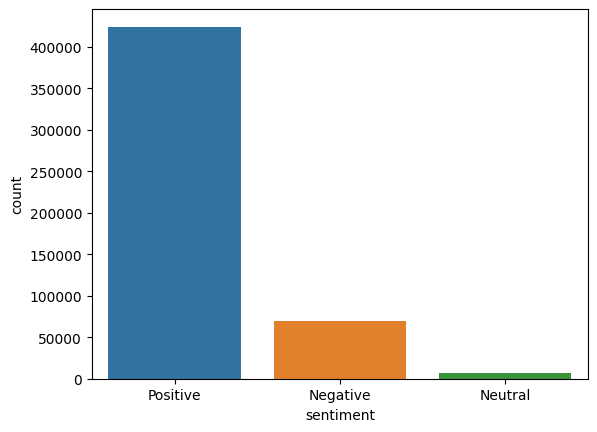

In [16]:
sns.countplot(x ='sentiment', data = plot_df)

In [17]:
# df.write.format("mongo").option('uri', 'mongodb://127.0.0.1')\
#     .option('database', 'bdm') \
#     .option('collection', 'final') \
#     .mode("overwrite") \
#     .save()